In [1]:
import os
HOME = os.getcwd()
print(HOME)

/kaggle/working


### Install dependencies

**NOTE:** Currently, YOLOv12 does not have its own PyPI package, so we install it directly from GitHub while also adding roboflow (to conveniently pull datasets from the Roboflow Universe), supervision (to visualize inference results and benchmark the model’s performance), and flash-attn (to accelerate attention-based computations via optimized CUDA kernels).

In [ ]:
import os

os.environ["ROBOFLOW_API_KEY"] = Robo_key

In [3]:
!pip install -q git+https://github.com/sunsmarterjie/yolov12.git roboflow supervision flash-attn

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 48.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.2/85.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Download example data

Let's download an image we can use for YOLOv12 inference. Feel free to drag and drop your own images into the Files tab on the left-hand side of Google Colab, then reference their filenames in your code for a custom inference demo.

## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

In [4]:
import cv2
from ultralytics import YOLO
import supervision as sv


# image_path = f"{HOME}/xcBYLI.png"
# image = cv2.imread(image_path)

# model = YOLO('yolov12l.pt')

# results = model(image, verbose=False)[0]
# detections = sv.Detections.from_ultralytics(results)

# box_annotator = sv.BoxAnnotator()
# label_annotator = sv.LabelAnnotator()

# annotated_image = image.copy()
# annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
# annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

# sv.plot_image(annotated_image)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/yolov12/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
FlashAttention is not available on this device. Using scaled_dot_product_attention instead.


## Download dataset from Roboflow Universe

In [5]:
from roboflow import download_dataset
dataset = download_dataset('https://universe.roboflow.com/labelling-24hrm/my-first-project-dar4n/dataset/2','yolov8')

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to My-First-Project-2 in yolov8:: 100%|██████████| 2924/2924 [00:00<00:00, 4427.11it/s]


In [6]:
!ls {dataset.location}

data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


**NOTE:** We need to make a few changes to our downloaded dataset so it will work with YOLOv12. Run the following bash commands to prepare your dataset for training by updating the relative paths in the `data.yaml` file, ensuring it correctly points to the subdirectories for your dataset's `train`, `test`, and `valid` subsets.

In [7]:
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!sed -i '$d' {dataset.location}/data.yaml
!echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [8]:
!cat {dataset.location}/data.yaml

names:
- car
- pedestrian
- traffic light
- traffic light-green
- traffic light-red
- traffic light-red_left
- traffic light-yellow
- truck
nc: 8
roboflow:
  license: CC BY 4.0
  project: my-first-project-dar4n
  url: https://universe.roboflow.com/labelling-24hrm/my-first-project-dar4n/dataset/2
  version: 2
test: ../test/images
train: ../train/images
val: ../valid/images


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [9]:
# from ultralytics import YOLO

# model = YOLO('yolov12s.yaml')

# results = model.train(data=f'{dataset.location}/data.yaml', epochs=100)

In [10]:
from ultralytics import YOLO

def progressive_unfreeze_callback(trainer):

    model = trainer.model
    epoch = trainer.epoch
    freeze_backbone_epochs = 30
    freeze_partial_epochs = 60

    # Phase 1: Freeze backbone (epochs 0)
    if epoch == 0:
        # Freeze backbone layers (0-8)
        freeze = [f'model.{x}.' for x in range(9)]
        for k, v in model.named_parameters():
            v.requires_grad = True
            if any(x in k for x in freeze):
                v.requires_grad = False
                print(f'Freezing {k}')
        print(f'Phase 1: Backbone frozen for {freeze_backbone_epochs} epochs')

    # Phase 2: Partial freeze (at epoch freeze_backbone_epochs)
    elif epoch == freeze_backbone_epochs:
        # Freeze early backbone layers (0-5)
        freeze = [f'model.{x}.' for x in range(6)]
        for k, v in model.named_parameters():
            v.requires_grad = True
            if any(x in k for x in freeze):
                v.requires_grad = False
                print(f'Freezing {k}')
        print(f'Phase 2: Partial backbone frozen until epoch {freeze_partial_epochs}')

    # Phase 3: Unfreeze all (at epoch freeze_partial_epochs)
    elif epoch == freeze_partial_epochs:
        for k, v in model.named_parameters():
            v.requires_grad = True
        print('Phase 3: All layers unfrozen for final training')

model = YOLO('yolov12s.yaml')
model.add_callback("on_train_epoch_start", progressive_unfreeze_callback)
results = model.train(
    data=f'{dataset.location}/data.yaml',
    epochs=100
)

New https://pypi.org/project/ultralytics/8.3.119 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov12s.yaml, data=/kaggle/working/My-First-Project-2/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, e

100%|██████████| 755k/755k [00:00<00:00, 4.09MB/s]
E0000 00:00:1745826660.228682      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745826660.282347      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Overriding model.yaml nc=80 with nc=8

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1      9344  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2, 1, 2]          
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1     37120  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2, 1, 4]        
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    677120  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.26M/5.26M [00:00<00:00, 19.2MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/My-First-Project-2/train/labels... 1019 images, 10 backgrounds, 0 corrupt: 100%|██████████| 1019/1019 [00:00<00:00, 1489.78it/s]


train: New cache created: /kaggle/working/My-First-Project-2/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
Argument(s) 'quality_lower' are not valid for transform ImageCompression
val: Scanning /kaggle/working/My-First-Project-2/valid/labels... 293 images, 2 backgrounds, 0 corrupt: 100%|██████████| 293/293 [00:00<00:00, 550.71it/s]

val: New cache created: /kaggle/working/My-First-Project-2/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 121 weight(decay=0.0), 128 weight(decay=0.0005), 127 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...
Freezing model.0.conv.weight
Freezing model.0.bn.weight
Freezing model.0.bn.bias
Freezing model.1.conv.weight
Freezing model.1.bn.weight
Freezing model.1.bn.bias
Freezing model.2.cv1.conv.weight
Freezing model.2.cv1.bn.weight
Freezing model.2.cv1.bn.bias
Freezing model.2.cv2.conv.weight
Freezing model.2.cv2.bn.weight
Freezing model.2.cv2.bn.bias
Freezing model.2.m.0.cv1.conv.weight
Freezing model.2.m.0.cv1.bn.weight
Freezing model.2.m.0.cv1.bn.bias
Freezing model.2.m.0.cv2.conv.wei

      1/100       2.2G      4.103      6.214      4.097         73        640: 100%|██████████| 64/64 [00:17<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.80it/s]


                   all        293       1332   9.95e-06   0.000166   8.97e-06   3.59e-06

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.04G      3.588      4.417      3.154         66        640: 100%|██████████| 64/64 [00:16<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        293       1332   1.32e-05   0.000166   8.96e-06   2.69e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.06G      3.203      3.512      2.573         77        640: 100%|██████████| 64/64 [00:16<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        293       1332      0.891     0.0265     0.0257    0.00683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.05G      2.849      2.977      2.224        120        640: 100%|██████████| 64/64 [00:16<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.20it/s]

                   all        293       1332      0.225      0.107     0.0569      0.021



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.07G      2.633      2.665      2.022         74        640: 100%|██████████| 64/64 [00:15<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.80it/s]

                   all        293       1332      0.228      0.105     0.0701     0.0293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.01G      2.455      2.445      1.878         72        640: 100%|██████████| 64/64 [00:15<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.17it/s]

                   all        293       1332      0.475      0.115     0.0906     0.0361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.06G      2.385      2.293       1.82         73        640: 100%|██████████| 64/64 [00:16<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        293       1332      0.509      0.108        0.1     0.0468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.02G      2.288       2.16      1.758        121        640: 100%|██████████| 64/64 [00:15<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]

                   all        293       1332      0.558      0.117      0.115     0.0554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.05G      2.234      2.073      1.698         89        640: 100%|██████████| 64/64 [00:16<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        293       1332      0.489      0.121      0.112     0.0536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.05G      2.157      2.008      1.669         72        640: 100%|██████████| 64/64 [00:15<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.86it/s]

                   all        293       1332      0.581      0.131      0.137     0.0672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         2G      2.114      1.928      1.622        104        640: 100%|██████████| 64/64 [00:15<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.14it/s]

                   all        293       1332       0.61      0.154      0.143      0.067



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.05G      2.086      1.876      1.605         87        640: 100%|██████████| 64/64 [00:16<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        293       1332      0.412      0.129      0.139     0.0751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.05G      1.982       1.81      1.552         70        640: 100%|██████████| 64/64 [00:15<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]

                   all        293       1332      0.464      0.122      0.147     0.0824



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.03G      2.019      1.821      1.554         64        640: 100%|██████████| 64/64 [00:16<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        293       1332      0.419      0.144      0.148     0.0768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.03G      1.962      1.725      1.509         74        640: 100%|██████████| 64/64 [00:15<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.81it/s]

                   all        293       1332      0.472      0.151      0.172     0.0922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.08G      1.943      1.727      1.509        109        640: 100%|██████████| 64/64 [00:15<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        293       1332      0.461      0.162      0.169     0.0891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100       2.2G        1.9      1.673      1.465         56        640: 100%|██████████| 64/64 [00:16<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]

                   all        293       1332      0.441      0.187      0.173     0.0932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.03G       1.89      1.669      1.458         49        640: 100%|██████████| 64/64 [00:16<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.22it/s]

                   all        293       1332      0.317      0.176      0.182      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.06G      1.899      1.657      1.459         39        640: 100%|██████████| 64/64 [00:16<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.22it/s]

                   all        293       1332      0.571      0.159      0.184     0.0953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.05G      1.873      1.636      1.429         86        640: 100%|██████████| 64/64 [00:16<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.89it/s]

                   all        293       1332      0.465      0.162      0.187      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.34G      1.838      1.577        1.4         74        640: 100%|██████████| 64/64 [00:16<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]

                   all        293       1332      0.458      0.177      0.186      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.09G      1.796      1.543      1.378         86        640: 100%|██████████| 64/64 [00:16<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        293       1332      0.429      0.171      0.197      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.03G      1.801      1.553      1.383         94        640: 100%|██████████| 64/64 [00:16<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]

                   all        293       1332      0.657      0.169      0.192      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.17G      1.775      1.547       1.37         75        640: 100%|██████████| 64/64 [00:16<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]

                   all        293       1332      0.356       0.17      0.195      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.03G      1.766      1.517      1.359         57        640: 100%|██████████| 64/64 [00:16<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.95it/s]

                   all        293       1332      0.485      0.183      0.194      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.02G      1.746      1.483      1.364         74        640: 100%|██████████| 64/64 [00:15<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.16it/s]

                   all        293       1332      0.423      0.204      0.201      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.02G      1.746      1.469      1.348         99        640: 100%|██████████| 64/64 [00:16<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.18it/s]

                   all        293       1332      0.709      0.174      0.204      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.02G      1.744      1.479      1.341         70        640: 100%|██████████| 64/64 [00:16<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.19it/s]

                   all        293       1332      0.341      0.198      0.205      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.33G      1.699      1.447       1.33         69        640: 100%|██████████| 64/64 [00:16<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.11it/s]

                   all        293       1332      0.487      0.218      0.218      0.121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.06G      1.671      1.391      1.294        100        640: 100%|██████████| 64/64 [00:16<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.90it/s]

                   all        293       1332      0.517      0.204      0.217      0.126


Freezing model.0.conv.weight
Freezing model.0.bn.weight
Freezing model.0.bn.bias
Freezing model.1.conv.weight
Freezing model.1.bn.weight
Freezing model.1.bn.bias
Freezing model.2.cv1.conv.weight
Freezing model.2.cv1.bn.weight
Freezing model.2.cv1.bn.bias
Freezing model.2.cv2.conv.weight
Freezing model.2.cv2.bn.weight
Freezing model.2.cv2.bn.bias
Freezing model.2.m.0.cv1.conv.weight
Freezing model.2.m.0.cv1.bn.weight
Freezing model.2.m.0.cv1.bn.bias
Freezing model.2.m.0.cv2.conv.weight
Freezing model.2.m.0.cv2.bn.weight
Freezing model.2.m.0.cv2.bn.bias
Freezing model.3.conv.weight
Freezing model.3.bn.weight
Freezing model.3.bn.bias
Freezing model.4.cv1.conv.weight
Freezing model.4.cv1.bn.weight
Freezing model.4.cv1.bn.bias
Freezing model.4.cv2.conv.weight
Freezing model.4.cv2.bn.weight
Freezing model.4.cv2.bn.bias
Freezing model.4.m.0.cv1.conv.weight
Freezing model.4.m.0.cv1.bn.weight
Freezing model.4.m.0.cv1.bn.bias
Freezing model.4.m.0.cv2.conv.weight
Freezing model.4.m.0.cv2.bn.weigh

     31/100      4.49G      1.761      1.474      1.338         83        640: 100%|██████████| 64/64 [00:26<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.93it/s]

                   all        293       1332      0.545     0.0712     0.0777     0.0423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      4.67G      1.668      1.406      1.291         98        640: 100%|██████████| 64/64 [00:26<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.13it/s]

                   all        293       1332      0.593       0.18      0.168     0.0866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      4.75G      1.665      1.388      1.287         83        640: 100%|██████████| 64/64 [00:26<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.19it/s]

                   all        293       1332      0.353      0.258      0.225      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      4.83G      1.633      1.359       1.28         94        640: 100%|██████████| 64/64 [00:26<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.17it/s]

                   all        293       1332      0.679      0.187      0.218      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100       4.8G      1.637      1.392      1.294         85        640: 100%|██████████| 64/64 [00:26<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.20it/s]

                   all        293       1332      0.545      0.194      0.227      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100       4.6G      1.652      1.358      1.284         56        640: 100%|██████████| 64/64 [00:26<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        293       1332      0.386      0.202      0.223      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      4.71G      1.665      1.374       1.28        117        640: 100%|██████████| 64/64 [00:26<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        293       1332      0.369       0.24      0.252      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      4.57G      1.612      1.334      1.274         57        640: 100%|██████████| 64/64 [00:26<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.16it/s]

                   all        293       1332      0.678      0.206      0.238      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100       4.8G      1.628      1.348      1.275        113        640: 100%|██████████| 64/64 [00:26<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        293       1332      0.564      0.269      0.261      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      4.53G      1.589      1.321      1.261        102        640: 100%|██████████| 64/64 [00:26<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

                   all        293       1332      0.706      0.224      0.249      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      4.64G      1.616      1.335      1.263        105        640: 100%|██████████| 64/64 [00:26<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]

                   all        293       1332      0.496       0.24      0.237      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      4.68G      1.615      1.317       1.26         75        640: 100%|██████████| 64/64 [00:26<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.19it/s]

                   all        293       1332       0.54       0.27       0.27       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      4.73G      1.599      1.311      1.251        105        640: 100%|██████████| 64/64 [00:26<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        293       1332      0.419      0.267      0.261       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      4.55G      1.567      1.282      1.247         85        640: 100%|██████████| 64/64 [00:26<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        293       1332      0.756      0.262      0.268      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      4.55G       1.56      1.268      1.231         67        640: 100%|██████████| 64/64 [00:26<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.88it/s]

                   all        293       1332      0.527      0.223      0.257      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      4.67G      1.555      1.268      1.228         79        640: 100%|██████████| 64/64 [00:26<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        293       1332      0.533      0.258      0.271      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      4.65G      1.574      1.283      1.239        101        640: 100%|██████████| 64/64 [00:26<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        293       1332      0.526      0.231      0.252      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      4.64G       1.54       1.26      1.228         71        640: 100%|██████████| 64/64 [00:26<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.37it/s]

                   all        293       1332      0.639      0.236      0.273      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      4.68G      1.533      1.242      1.209         91        640: 100%|██████████| 64/64 [00:26<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        293       1332      0.552      0.313      0.278      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      4.63G      1.511      1.224      1.213         96        640: 100%|██████████| 64/64 [00:26<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.14it/s]

                   all        293       1332      0.571      0.305      0.281      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      4.83G      1.543      1.258       1.22         83        640: 100%|██████████| 64/64 [00:26<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.07it/s]

                   all        293       1332       0.49      0.299      0.284       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      4.66G       1.51      1.216      1.206         56        640: 100%|██████████| 64/64 [00:26<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.09it/s]

                   all        293       1332      0.571      0.277      0.294      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      4.71G      1.501      1.215      1.195         93        640: 100%|██████████| 64/64 [00:26<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.09it/s]

                   all        293       1332      0.548      0.327      0.302      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      4.51G       1.46      1.185      1.197         67        640: 100%|██████████| 64/64 [00:26<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.29it/s]

                   all        293       1332       0.44      0.303      0.278      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      4.56G      1.521      1.227      1.193        107        640: 100%|██████████| 64/64 [00:26<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.22it/s]

                   all        293       1332      0.505      0.266      0.278       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100       4.8G      1.514      1.215      1.197         97        640: 100%|██████████| 64/64 [00:26<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.23it/s]

                   all        293       1332      0.509      0.311       0.29      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      4.55G      1.477      1.199      1.188        104        640: 100%|██████████| 64/64 [00:26<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        293       1332      0.505      0.337      0.304      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      4.67G      1.451      1.168      1.172         88        640: 100%|██████████| 64/64 [00:26<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        293       1332      0.505      0.307      0.292      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      4.57G      1.497      1.193      1.196        130        640: 100%|██████████| 64/64 [00:26<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.16it/s]

                   all        293       1332      0.557       0.33      0.308      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      4.66G       1.45      1.157      1.185         71        640: 100%|██████████| 64/64 [00:26<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

                   all        293       1332       0.63      0.317      0.312       0.17


Phase 3: All layers unfrozen for final training

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      7.09G      1.446      1.175       1.17         87        640: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        293       1332      0.619      0.295      0.312      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      7.12G      1.381      1.115      1.154         54        640: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        293       1332      0.437      0.341      0.345      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      7.11G      1.331      1.073      1.134         65        640: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.22it/s]

                   all        293       1332      0.614      0.332      0.343        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      7.09G      1.318      1.093      1.126         93        640: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.26it/s]

                   all        293       1332      0.533      0.383      0.335      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      7.09G      1.286      1.041      1.121        102        640: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        293       1332      0.644      0.327      0.343      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      7.08G      1.263      1.038      1.113        119        640: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        293       1332      0.574       0.36       0.35        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      7.12G      1.287      1.053      1.124         72        640: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        293       1332      0.605      0.331       0.35      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      7.15G       1.24      1.006      1.099         44        640: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        293       1332      0.617      0.369      0.382      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      7.09G      1.278      1.041      1.109         60        640: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        293       1332      0.573      0.349      0.354      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      7.09G      1.231      1.006      1.101         57        640: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.19it/s]

                   all        293       1332      0.561      0.343      0.346      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      7.15G      1.218      1.002      1.099         60        640: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        293       1332      0.525      0.376      0.351      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      6.92G      1.206     0.9928      1.097         50        640: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]

                   all        293       1332      0.597      0.358      0.356      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      7.07G      1.218     0.9867      1.089         61        640: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.22it/s]

                   all        293       1332      0.544      0.373      0.347      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      7.08G      1.194     0.9623      1.091        104        640: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        293       1332      0.381       0.42      0.374       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      7.12G      1.191      0.964      1.081         74        640: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.31it/s]

                   all        293       1332      0.577      0.425      0.363      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      7.07G        1.2     0.9897      1.092         76        640: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        293       1332      0.569      0.356      0.357      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      7.14G      1.166     0.9502      1.075         89        640: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        293       1332      0.571      0.404      0.378      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      7.06G      1.169     0.9482      1.069         64        640: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.06it/s]

                   all        293       1332       0.54      0.383      0.363      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      6.91G      1.174     0.9592       1.08        101        640: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.39it/s]

                   all        293       1332      0.574      0.364      0.349       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      7.06G      1.138     0.9353      1.056         59        640: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.24it/s]

                   all        293       1332       0.59      0.395      0.368      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100       6.9G       1.14     0.9401      1.069         82        640: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.15it/s]

                   all        293       1332      0.498      0.409      0.356      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      7.07G      1.164     0.9316      1.065         95        640: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        293       1332      0.571      0.381      0.372      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      6.96G      1.123     0.9133      1.057         68        640: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.01it/s]

                   all        293       1332      0.651      0.341      0.376      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      7.09G      1.113     0.9021      1.054         73        640: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.20it/s]

                   all        293       1332      0.572      0.419      0.367      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      7.08G      1.145     0.9289      1.053         85        640: 100%|██████████| 64/64 [00:37<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        293       1332      0.586       0.39      0.372      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.97G      1.096     0.8924      1.049         85        640: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

                   all        293       1332        0.6      0.375      0.377      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      6.94G      1.113     0.9028       1.06         80        640: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.07it/s]

                   all        293       1332      0.579      0.368      0.372      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      7.08G      1.113     0.9083      1.055         83        640: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.25it/s]

                   all        293       1332      0.631      0.371      0.368      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      6.89G      1.084     0.8767      1.039         61        640: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.30it/s]

                   all        293       1332      0.357      0.436      0.376       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      6.98G       1.11      0.896      1.049         82        640: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.32it/s]

                   all        293       1332      0.589      0.414      0.377      0.235


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


Argument(s) 'quality_lower' are not valid for transform ImageCompression



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      6.95G      1.057     0.8686      1.033         33        640: 100%|██████████| 64/64 [00:38<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        293       1332      0.351      0.381      0.366      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100       7.1G      1.035      0.847      1.026         59        640: 100%|██████████| 64/64 [00:37<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        293       1332      0.585        0.4       0.37      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      7.06G      1.035     0.8379      1.021         48        640: 100%|██████████| 64/64 [00:37<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.36it/s]

                   all        293       1332      0.438       0.46      0.381      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.96G      1.015     0.8291      1.012         40        640: 100%|██████████| 64/64 [00:37<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.44it/s]

                   all        293       1332      0.595      0.396      0.368      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      6.89G      1.022     0.8367      1.023         33        640: 100%|██████████| 64/64 [00:37<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        293       1332      0.602      0.444      0.374      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      7.12G      1.019     0.8276      1.017         52        640: 100%|██████████| 64/64 [00:37<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.96it/s]

                   all        293       1332      0.421      0.417      0.376      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      7.11G     0.9954     0.8215      1.007         50        640: 100%|██████████| 64/64 [00:37<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  3.92it/s]

                   all        293       1332      0.399      0.454      0.384      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      6.92G      1.005     0.8213      1.016         31        640: 100%|██████████| 64/64 [00:37<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.27it/s]

                   all        293       1332      0.389      0.456       0.38      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      7.11G     0.9962     0.8124      1.002         31        640: 100%|██████████| 64/64 [00:38<00:00,  1.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.28it/s]

                   all        293       1332      0.435      0.422      0.379      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      6.96G     0.9997     0.8186      1.014         36        640: 100%|██████████| 64/64 [00:37<00:00,  1.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:02<00:00,  4.33it/s]

                   all        293       1332      0.396      0.443      0.381      0.242



100 epochs completed in 0.877 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv12s summary (fused): 376 layers, 9,077,304 parameters, 0 gradients, 19.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  2.84it/s]


                   all        293       1332      0.609      0.359      0.376      0.246
                   car        285        861      0.649      0.815      0.832      0.615
            pedestrian         50         84      0.692      0.333      0.438      0.198
         traffic light         48         79       0.73      0.127      0.225       0.15
   traffic light-green         19         19      0.265      0.105     0.0548      0.031
     traffic light-red        108        247      0.772      0.842      0.819      0.598
  traffic light-yellow          3          4          1          0    0.00242    0.00169
                 truck         38         38      0.158      0.289      0.259      0.129


invalid value encountered in less
invalid value encountered in less


Speed: 0.1ms preprocess, 5.0ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train


## Evaluate fine-tuned YOLOv12 model

In [11]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!ls {HOME}/runs/detect/train/

args.yaml					  train_batch1.jpg
confusion_matrix_normalized.png			  train_batch2.jpg
confusion_matrix.png				  train_batch5760.jpg
events.out.tfevents.1745826670.af4be12b7681.19.0  train_batch5761.jpg
F1_curve.png					  train_batch5762.jpg
labels_correlogram.jpg				  val_batch0_labels.jpg
labels.jpg					  val_batch0_pred.jpg
P_curve.png					  val_batch1_labels.jpg
PR_curve.png					  val_batch1_pred.jpg
R_curve.png					  val_batch2_labels.jpg
results.csv					  val_batch2_pred.jpg
results.png					  weights
train_batch0.jpg


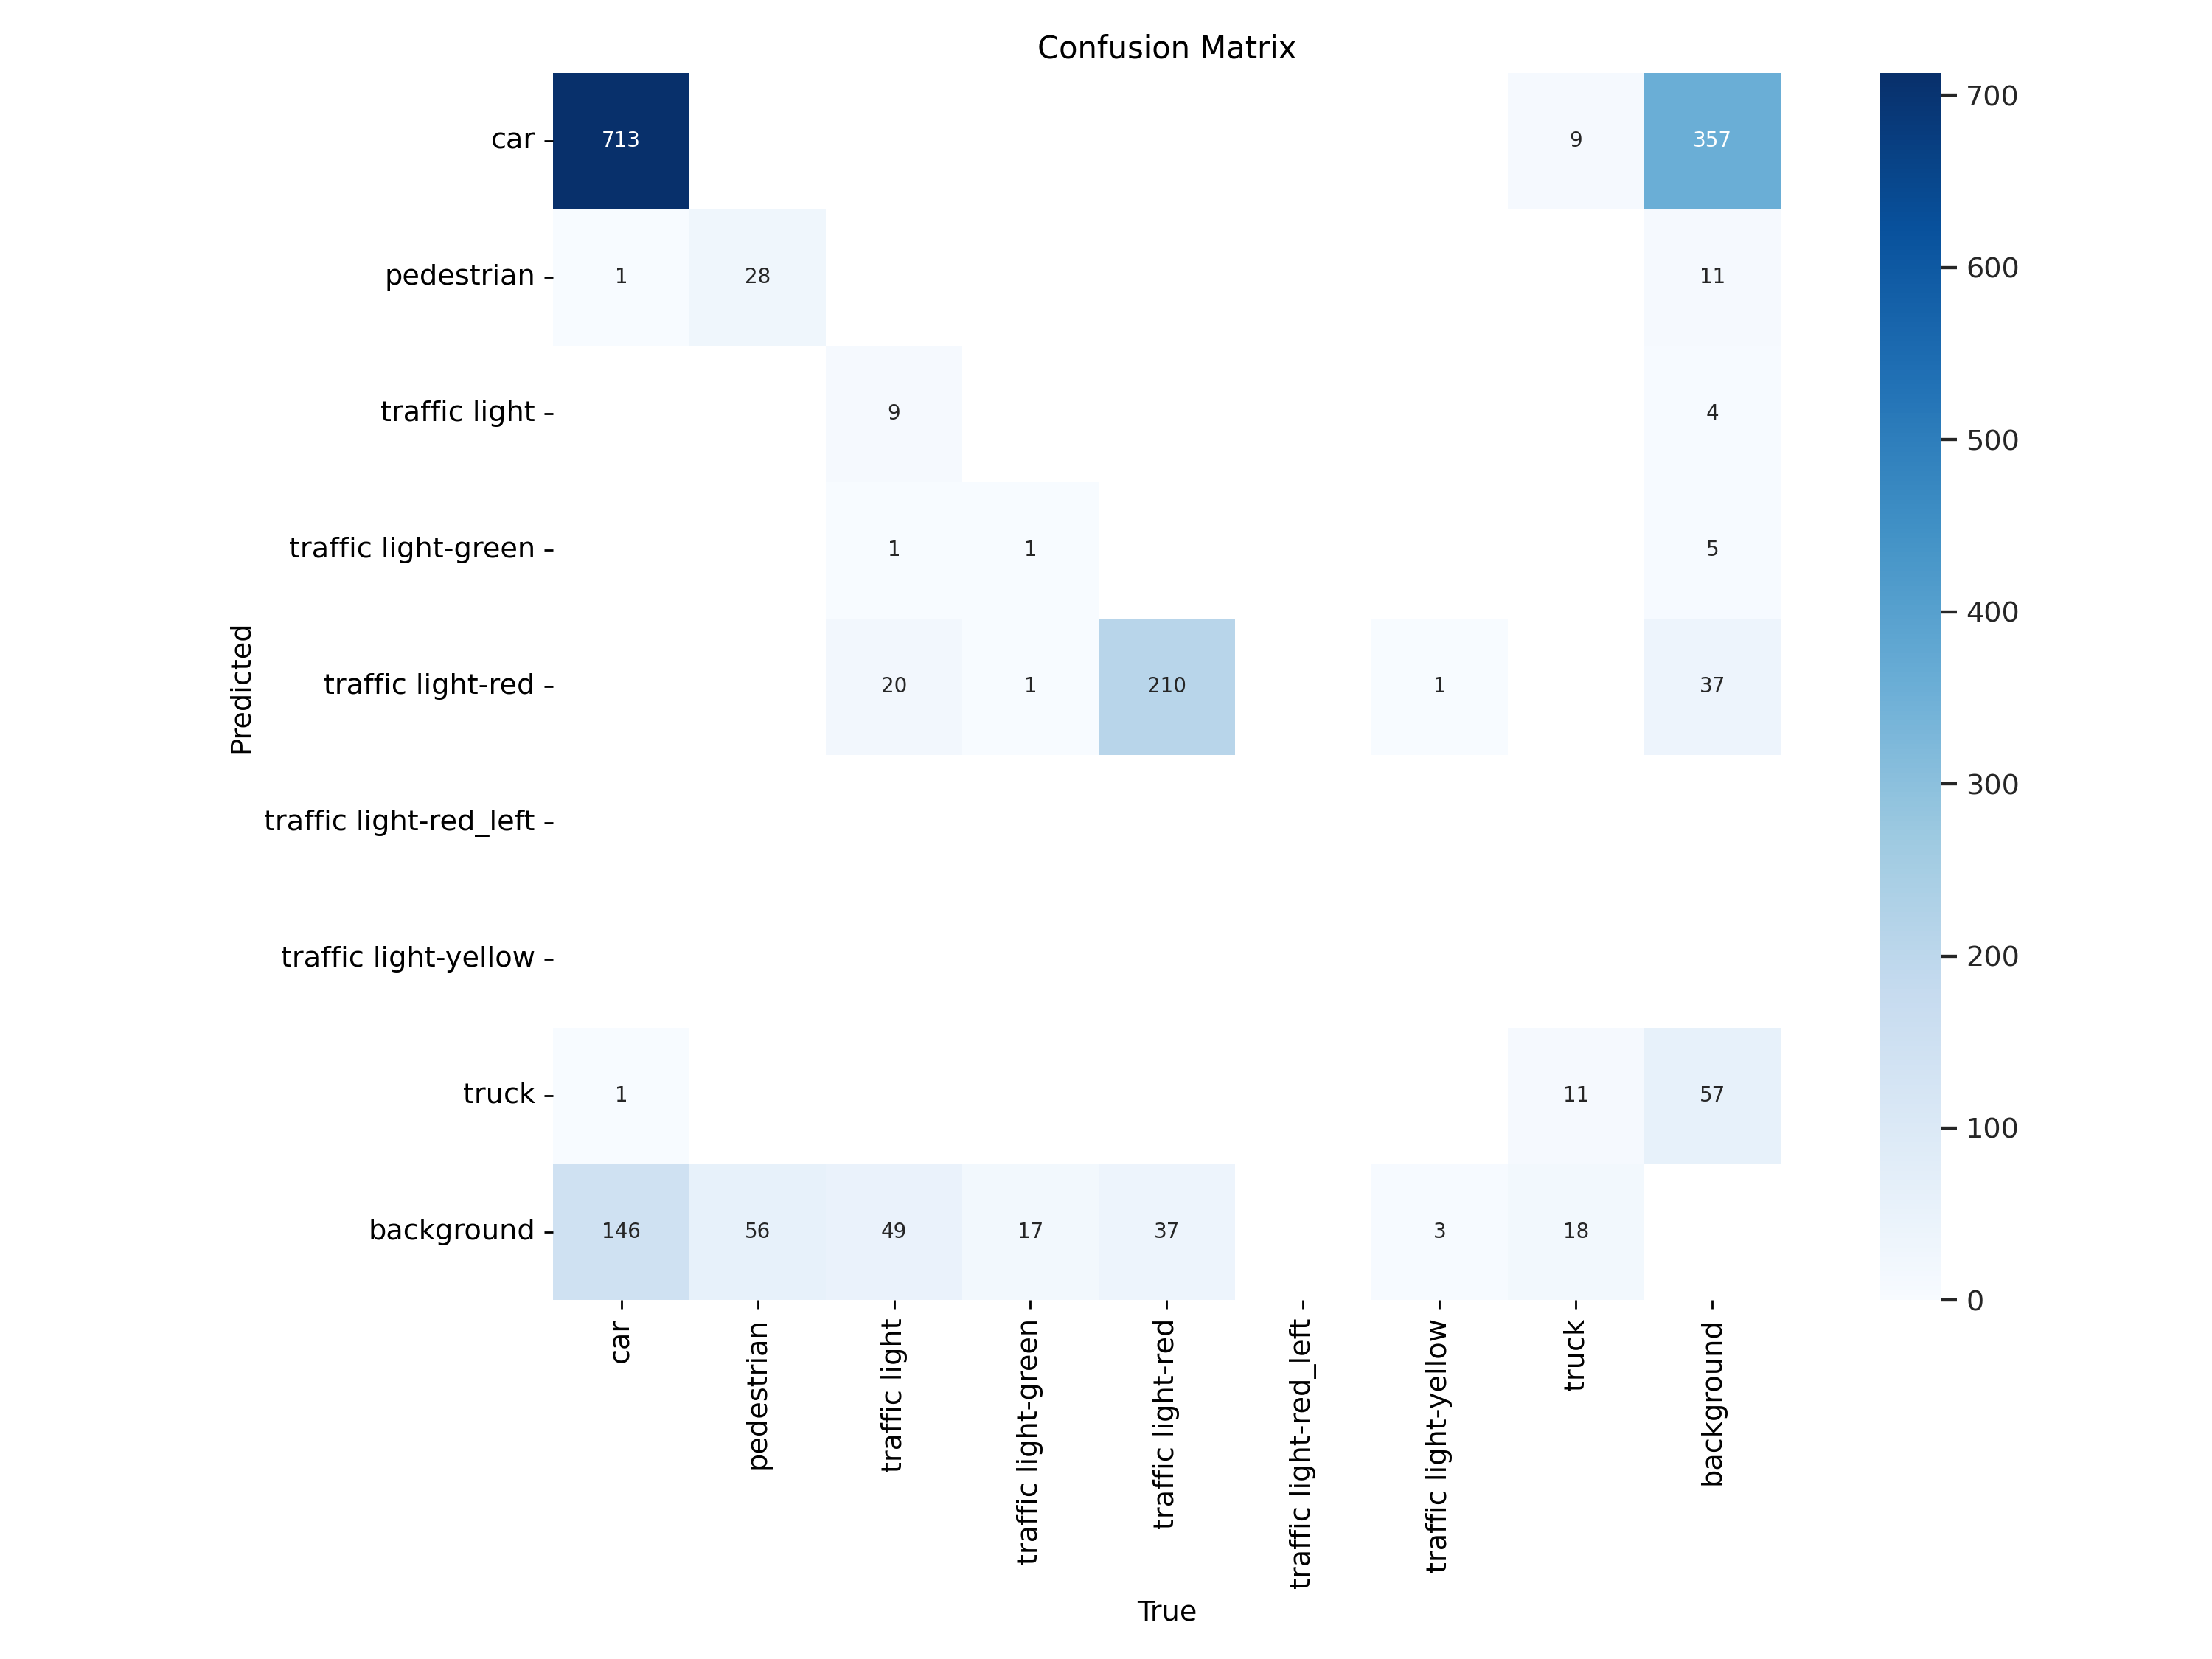

In [12]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=1000)

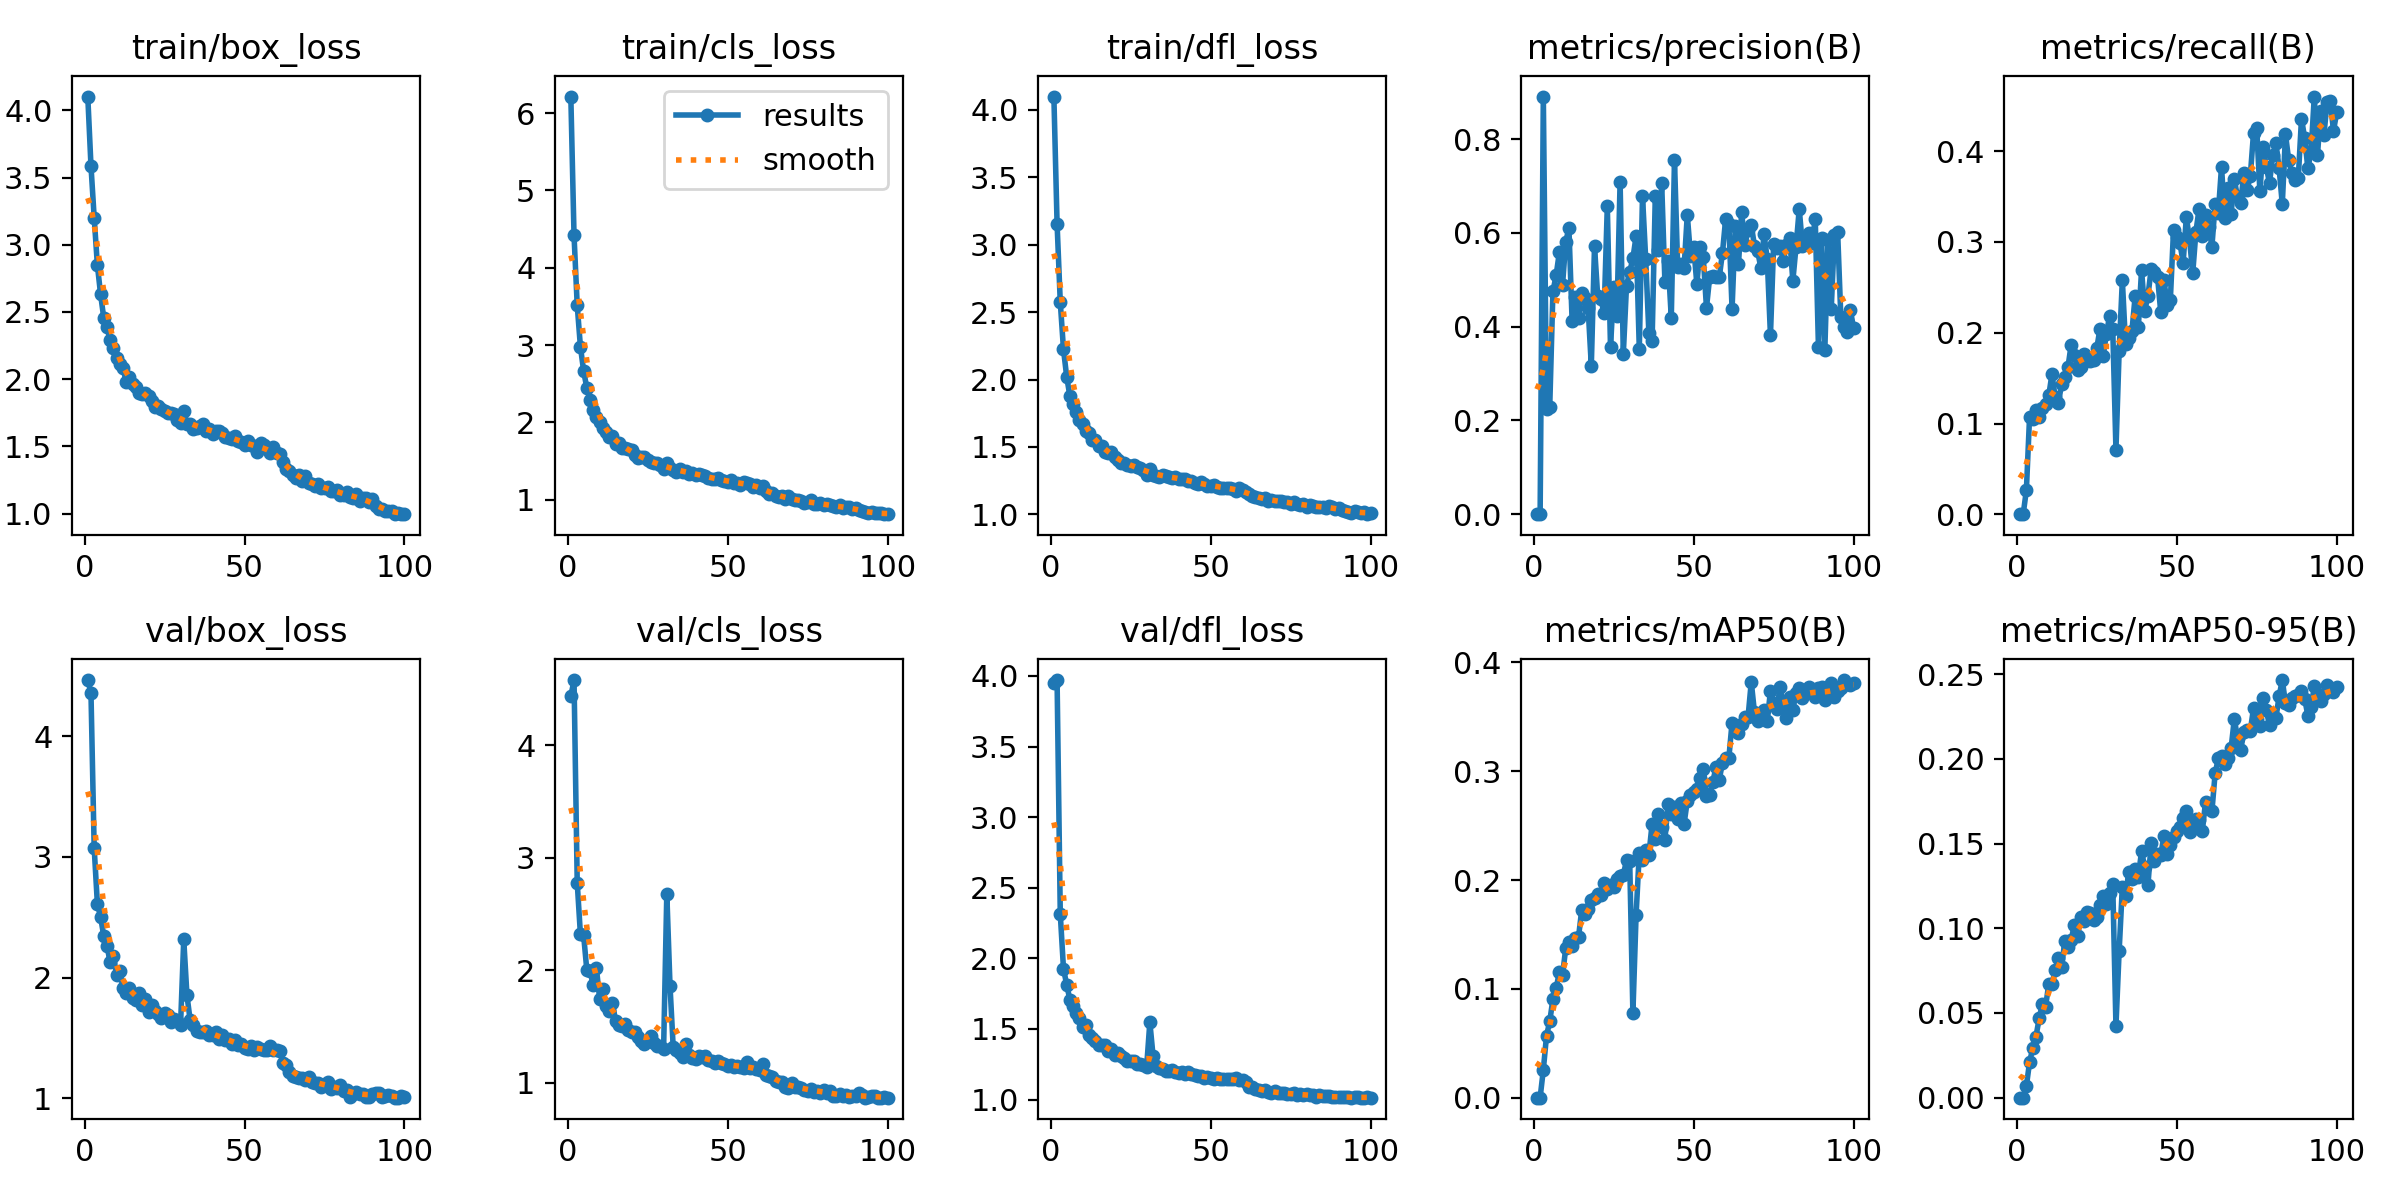

In [13]:
from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=1000)

In [14]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

ds.classes

['car',
 'pedestrian',
 'traffic light',
 'traffic light-green',
 'traffic light-red',
 'traffic light-red_left',
 'traffic light-yellow',
 'truck']

In [15]:
from supervision.metrics import MeanAveragePrecision

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [16]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.23136254095448794
mAP 50 0.363580348094207
mAP 75 0.24572352225072502


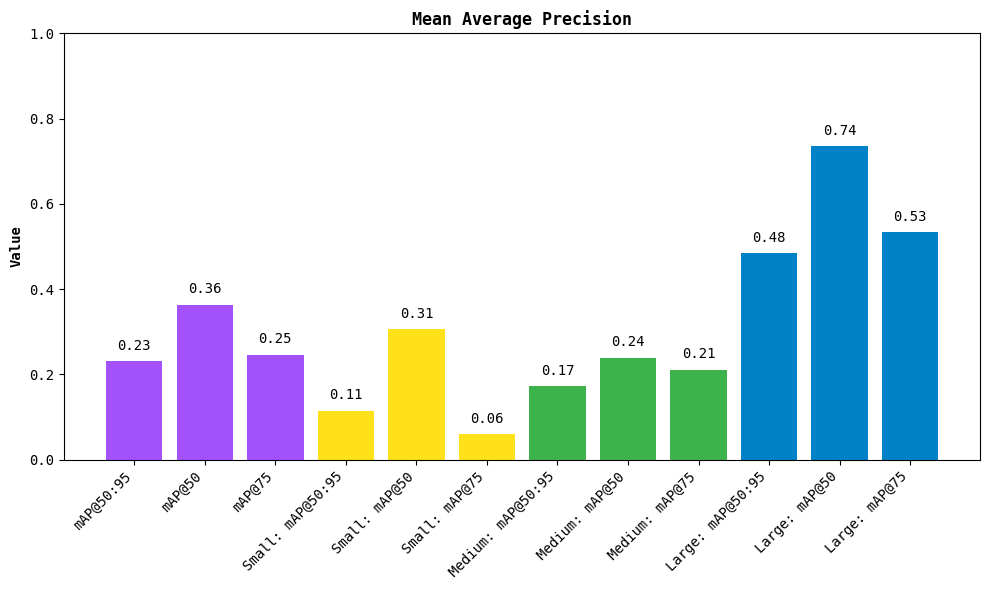

In [17]:
map.plot()

## Run inference with fine-tuned YOLOv12 model

In [18]:
import supervision as sv

model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

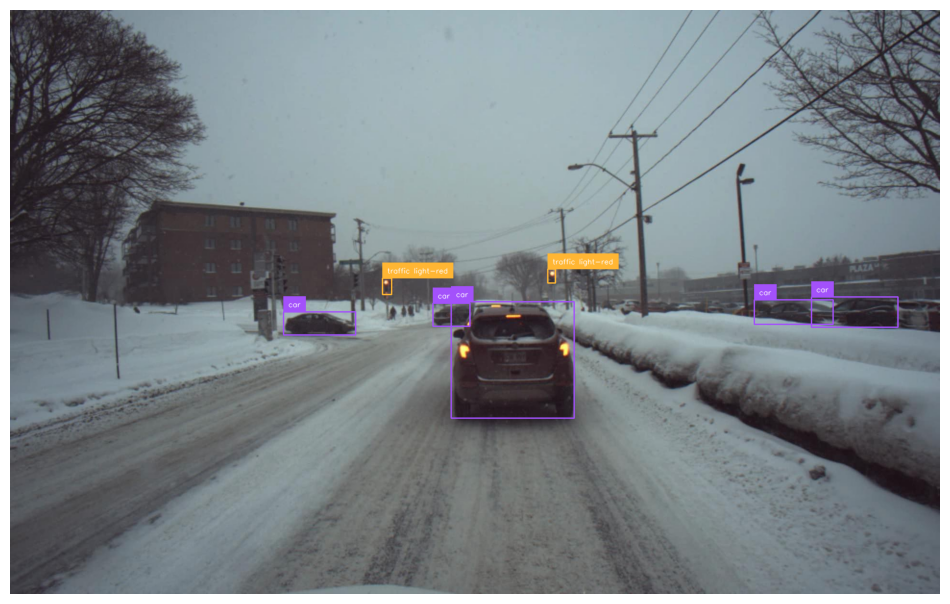

In [19]:
import random

i = random.randint(0, len(ds))

image_path, image, target = ds[i]

results = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results).with_nms()

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = image.copy()
annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)

In [20]:
from ultralytics import YOLO
import pandas as pd

# Load your fine-tuned model
model = YOLO(f'/{HOME}/runs/detect/train/weights/best.pt')

# Run validation to get detailed metrics
results = model.val(data=f'{dataset.location}/data.yaml')

# Create a DataFrame to store class-specific metrics
class_metrics = []

# Get class names
class_names = results.names

# Extract metrics for each class
for i, class_idx in enumerate(results.box.ap_class_index):
    class_name = class_names[class_idx]
    metrics = {
        'class': class_name,
        'precision': results.box.p[i],
        'recall': results.box.r[i],
        'f1': results.box.f1[i],
        'mAP50': results.box.ap50[i],
        'mAP50-95': results.box.ap[i]
    }
    class_metrics.append(metrics)

# Create DataFrame
df = pd.DataFrame(class_metrics)
print(df)


Ultralytics 8.3.63 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv12s summary (fused): 376 layers, 9,077,304 parameters, 0 gradients, 19.3 GFLOPs


val: Scanning /kaggle/working/My-First-Project-2/valid/labels.cache... 293 images, 2 backgrounds, 0 corrupt: 100%|██████████| 293/293 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.38it/s]


                   all        293       1332      0.651      0.342      0.376      0.247
                   car        285        861      0.702      0.804      0.834      0.617
            pedestrian         50         84      0.771       0.31      0.435        0.2
         traffic light         48         79        0.8      0.101      0.226      0.149
   traffic light-green         19         19      0.348      0.105     0.0548      0.031
     traffic light-red        108        247      0.776      0.834      0.818      0.599
  traffic light-yellow          3          4          1          0    0.00241    0.00169
                 truck         38         38      0.157      0.237       0.26       0.13


invalid value encountered in less
invalid value encountered in less


Speed: 0.1ms preprocess, 5.8ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/val
                  class  precision    recall        f1     mAP50  mAP50-95
0                   car   0.701699  0.803717  0.749251  0.833985  0.617318
1            pedestrian   0.771045  0.309524  0.441724  0.435054  0.199742
2         traffic light   0.799919  0.101220  0.179701  0.226115  0.149422
3   traffic light-green   0.348148  0.105263  0.161651  0.054817  0.030991
4     traffic light-red   0.775971  0.834008  0.803943  0.817836  0.599019
5  traffic light-yellow   1.000000  0.000000  0.000000  0.002415  0.001690
6                 truck   0.156874  0.236842  0.188737  0.260345  0.130331
